# Introduction

The purpose of this notebook is to present the basics of Spark: why we use it, and what kind of operations we can perform using it.

In this notebook we cover the following topics:
- SparkContext object
- RDDs
- Operations on RDDs:
    - transformations
    - actions
- DataFrames

## SparkContext

First of all, we need to create a driver Spark application which communicates the user commands to the Spark Workers. We do so with the help of the `SparkContext` object, which coordinates with the cluster manager about the resources required for execution and the actual tasks that need to be executed. The resources required can be defined within the `SparkConf` configuration object, which we pass as a parameter to the `SparkContext` object upon creation.

Once we create a `SparkContext (sc)` object, we use it for orchestrating the allocated resources. The process is illustrated on the image below. Each of the components on the image run in a different process, enabling parallel execution of the worker nodes. This setup is replicated for all applications submitted to the cluster, and due to the process isolation, they cannot communicate directly (exchange data) among each other without persisting it to the disk.

For more information on how Spark applications are deployed, please refer to the following resources:
- [Submitting Spark Applications](https://spark.apache.org/docs/latest/submitting-applications.html)
- [Cluster Mode Overview](https://spark.apache.org/docs/latest/submitting-applications.html)

![SparkContext overview](data/cluster_overview.png)

Image source: https://spark.apache.org/docs/latest/cluster-overview.html





In [1]:
import sys
from random import random
from pyspark import SparkContext, SparkConf

# Create a SparkConf configuration object which sets the Spark Application name
conf = SparkConf().setAppName("Spark Intro").setMaster("local[1]") # reserve 1 core

# Create the SparkContext object.
# In this case we are using `.getOrCreate` method to be able to rerun the same cell multiple times
sc = SparkContext.getOrCreate(conf=conf) # Alternatively, use SparkContext(conf=conf)

## Resilient Distributed Datasets - RDDs

Resilient Distributed Dataset (RDD) is the elementary data structure used in Spark. RDDs are immutable and fault-tolerant, meaning that once loaded, the data cannot be changed, and because of that the system is able to recalculate results from failing nodes. RDDs also enable operations on the enclosed data to be executed in parallel on multiple nodes.

There are 3 main ways of creating RDDs:
1. From an existing collection - parallelize the existing collection from the target programming language, such as an array.
2. Transforming an existing RDD - applying transformations on an RDD yields a new RDD.
3. Loading an external dataset - ability to load data from an existing source (e.g. from a file system)

There are 2 types of operations that can be applied to RDDs:
1. Transformations - a lazy operation which yields a new RDD
2. Actions - return a value to the driver program, i.e. execute all the predefined lazy operations of the RDD

We are going to explore all of these options in the examples below.


### Creating RDDs

In [2]:
intro_rdd = sc.parallelize(range(20), 8)

print(f"The assigned ID of the RDD: {intro_rdd.id()}")

intro_rdd.setName("Example RDD")
print(f"Name of the RDD: {intro_rdd.name()}")

The assigned ID of the RDD: 1
Name of the RDD: Example RDD


In [3]:
# Caching the intermediate results
# it is useful when loading big thrid party datasets into memory,
# so you do not have to reaload the data every time you perform an action
intro_rdd.cache().collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

### Types of caching
Depending on where you would like to cache the data, there are multiple types of caching:
- DISK_ONLY - serialized, on disk
- MEMORY_ONLY - deserialized, in memory
- MEMORY_AND_DISK - if not enough memory, spill to disk
- OFF_HEAP - outside the process' allocated memory (heap), not processed by the garbage collector


### RDD partitioning
Partitions are the main unit of parallelism in Spark. Split the data so that it can be managed in parallel.
The partitions are in-memory, so they are not stored in the disk, unless there is no sufficient space.

Usually the default number of partitions is the number of cores on the worker. So each worker gets a single partition to
perform the computations and return the results to the driver program.

In [4]:
print(f"Number of partitions: {intro_rdd.getNumPartitions()}") 
print(f"Data per partitions: {intro_rdd.glom().collect()}") # glom takes the data from the partitions

Number of partitions: 8
Data per partitions: [[0, 1], [2, 3, 4], [5, 6], [7, 8, 9], [10, 11], [12, 13, 14], [15, 16], [17, 18, 19]]


### Managing the partitions

It often makes sense to manage the partitions, how many there are and how the data is distributed among partitions.
We would like to have an optimal amount of partitions based on the problem that we are trying to solve.

If there are too many partitions then the scheduler is going to have trouble allocating enough resources for them,
resulting in spending more time then previously required.

On the other hand, if there are too few partitions, it can result in lack of parallelism, thus underutilized resources.

### Repartitioning

One way of managing the partitions is to use `repartition`. This method fully shuffles the partitions and the data,
and that is why it is a very *expensive* process, involving: data serialization, moving among partitions, data deserialization.

This method is usually used when increasing the number of partitions, but in this example we are going to demonstrate a
decrease in the number of partitions, to illustrate their effect.

In [5]:
repartitioned_rdd = intro_rdd.repartition(6) # full shuffle
print(f"Number of partitions: {repartitioned_rdd.getNumPartitions()}") 
print(f"Data per partitions: {repartitioned_rdd.glom().collect()}")

Number of partitions: 6
Data per partitions: [[], [0, 1, 12, 13, 14], [7, 8, 9, 10, 11], [], [5, 6, 15, 16, 17, 18, 19], [2, 3, 4]]


### Coalesce

Coalesce is another way of managing the partitions, and it tries avoiding a full shuffle operation.
It works in such a way, that it tries not to leave any empty partitions.


In [6]:
coalesced = intro_rdd.coalesce(6)
print(f'Number of partitions: {coalesced.getNumPartitions()}')
print(f'Data per partitions: {coalesced.glom().collect()}')

Number of partitions: 6
Data per partitions: [[0, 1, 17, 18, 19], [2, 3, 4], [7, 8, 9, 15, 16], [10, 11], [5, 6], [12, 13, 14]]


### RDD operations

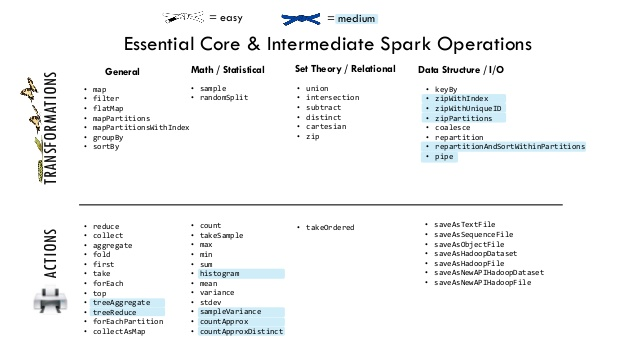
Image source: https://training.databricks.com/visualapi.pdf

In [7]:
transformed_rdd = intro_rdd.\
                    filter(lambda x: x % 3 == 0).\
                    map(lambda x: x + 1)
print(f"Result: {transformed_rdd.collect()}")

Result: [1, 4, 7, 10, 13, 16, 19]


In [8]:
sum_rdd = intro_rdd.\
                    filter(lambda x: x % 3 == 0).\
                    map(lambda x: x + 1).\
                    reduce(lambda x, y: x + y)
print(f"Result: {sum_rdd}")


Result: 70


In [9]:
# Finally, stop the application.
sc.stop()